Article: TBA\
Code: Customer Sales Prediction using Linear Regression, Random Forest, XG Boost, and LSTM\
Dataset Link: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data\
Prepared By: Awais Naeem (awais.naeem@embedded-robotics.com)\
Copyrights: www.embedded-robotics.com\
Disclaimer: This code can be distributed with the proper mention of the owner copyrights

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [22]:
store_sales = pd.read_csv('store_sale.csv')
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [23]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [24]:
store_sales = store_sales.drop(['store','item'], axis=1)

In [25]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [26]:
store_sales['date'] = store_sales['date'].dt.to_period('M')

In [27]:
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [28]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


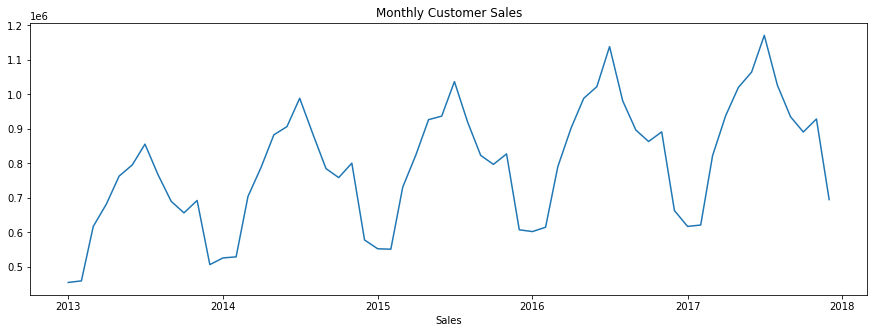

In [29]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.xlabel('Sales')
plt.title("Monthly Customer Sales")
plt.show()

In [30]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()

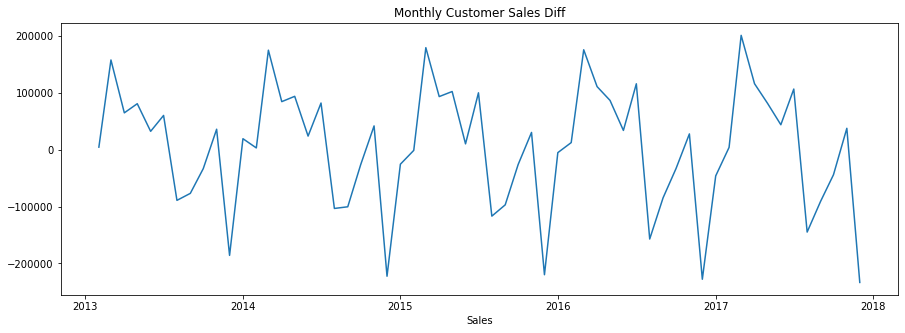

In [31]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel('Date')
plt.xlabel('Sales')
plt.title("Monthly Customer Sales Diff")
plt.show()

In [32]:
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


In [33]:
supverised_data = monthly_sales.drop(['date','sales'], axis=1)

In [34]:
for i in range(1,13):
    col_name = 'month_' + str(i)
    supverised_data[col_name] = supverised_data['sales_diff'].shift(i)

In [35]:
supverised_data = supverised_data.dropna().reset_index(drop=True)

In [36]:
train_data = supverised_data[:-12]
test_data = supverised_data[-12:]
print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)

Train Data Shape: (35, 13)
Test Data Shape: (12, 13)


In [37]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)

MinMaxScaler(feature_range=(-1, 1))

In [38]:
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [39]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)


X_train Shape: (35, 12)
y_train Shape: (35, 1)
X_test Shape: (12, 12)
y_test Shape: (12, 1)


In [40]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [41]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [42]:
act_sales = monthly_sales['sales'][-13:].to_list()

#### Linear Regression

In [43]:
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
linreg_pred = linreg_model.predict(X_test)

In [44]:
linreg_pred = linreg_pred.reshape(-1,1)
linreg_pred_test_set = np.concatenate([linreg_pred,X_test], axis=1)
linreg_pred_test_set = scaler.inverse_transform(linreg_pred_test_set)

In [45]:
result_list = []
for index in range(0, len(linreg_pred_test_set)):
    result_list.append(linreg_pred_test_set[index][0] + act_sales[index])
linreg_pred_series = pd.Series(result_list,name='linreg_pred')
predict_df = predict_df.merge(linreg_pred_series, left_index=True, right_index=True)

In [46]:
linreg_rmse = np.sqrt(mean_squared_error(predict_df['linreg_pred'], monthly_sales['sales'][-12:]))
linreg_mae = mean_absolute_error(predict_df['linreg_pred'], monthly_sales['sales'][-12:])
linreg_r2 = r2_score(predict_df['linreg_pred'], monthly_sales['sales'][-12:])
print('Linear Regression RMSE: ', linreg_rmse)
print('Linear Regression MAE: ', linreg_mae)
print('Linear Regression R2 Score: ', linreg_r2)

Linear Regression RMSE:  16221.272385416856
Linear Regression MAE:  12433.184266490774
Linear Regression R2 Score:  0.9906152516380969


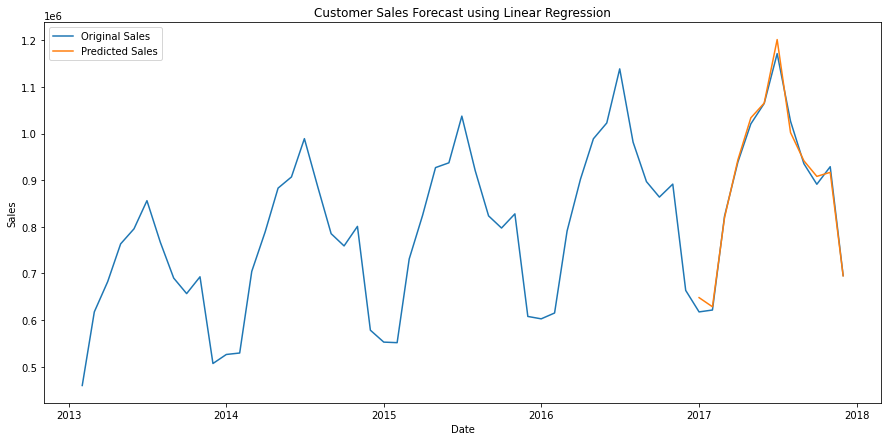

In [47]:
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['linreg_pred'])
plt.title("Customer Sales Forecast using Linear Regression")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

#### Random Forest

In [48]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [49]:
rf_pred = rf_pred.reshape(-1,1)
rf_pred_test_set = np.concatenate([rf_pred,X_test], axis=1)
rf_pred_test_set = scaler.inverse_transform(rf_pred_test_set)

In [50]:
result_list = []
for index in range(0, len(rf_pred_test_set)):
    result_list.append(rf_pred_test_set[index][0] + act_sales[index])
rf_pred_series = pd.Series(result_list, name='rf_pred')
predict_df = predict_df.merge(rf_pred_series, left_index=True, right_index=True)

In [51]:
rf_rmse = np.sqrt(mean_squared_error(predict_df['rf_pred'], monthly_sales['sales'][-12:]))
rf_mae = mean_absolute_error(predict_df['rf_pred'], monthly_sales['sales'][-12:])
rf_r2 = r2_score(predict_df['rf_pred'], monthly_sales['sales'][-12:])
print('Random Forest RMSE: ', rf_rmse)
print('Random Forest MAE: ', rf_mae)
print('Random Forest R2 Score: ', rf_r2)

Random Forest RMSE:  19317.618256092064
Random Forest MAE:  15939.693333333367
Random Forest R2 Score:  0.9857317477734233


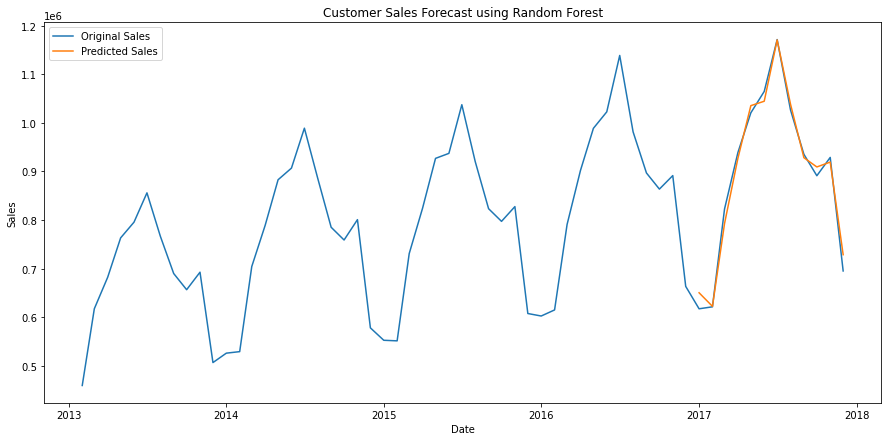

In [52]:
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['rf_pred'])
plt.title("Customer Sales Forecast using Random Forest")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

#### XG Boost

In [53]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.2, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

In [54]:
xgb_pred = xgb_pred.reshape(-1,1)
xgb_pred_test_set = np.concatenate([xgb_pred,X_test], axis=1)
xgb_pred_test_set = scaler.inverse_transform(xgb_pred_test_set)

In [55]:
result_list = []
for index in range(0, len(xgb_pred_test_set)):
    result_list.append(xgb_pred_test_set[index][0] + act_sales[index])
xgb_pred_series = pd.Series(result_list, name='xgb_pred')
predict_df = predict_df.merge(xgb_pred_series, left_index=True, right_index=True)

In [56]:
xgb_rmse = np.sqrt(mean_squared_error(predict_df['xgb_pred'], monthly_sales['sales'][-12:]))
xgb_mae = mean_absolute_error(predict_df['xgb_pred'], monthly_sales['sales'][-12:])
xgb_r2 = r2_score(predict_df['xgb_pred'], monthly_sales['sales'][-12:])
print('XG Boost RMSE: ', xgb_rmse)
print('XG Boost MAE: ', xgb_mae)
print('XG Boost R2 Score: ', xgb_r2)

XG Boost RMSE:  15701.124706426719
XG Boost MAE:  13342.738751299059
XG Boost R2 Score:  0.9907513141349301


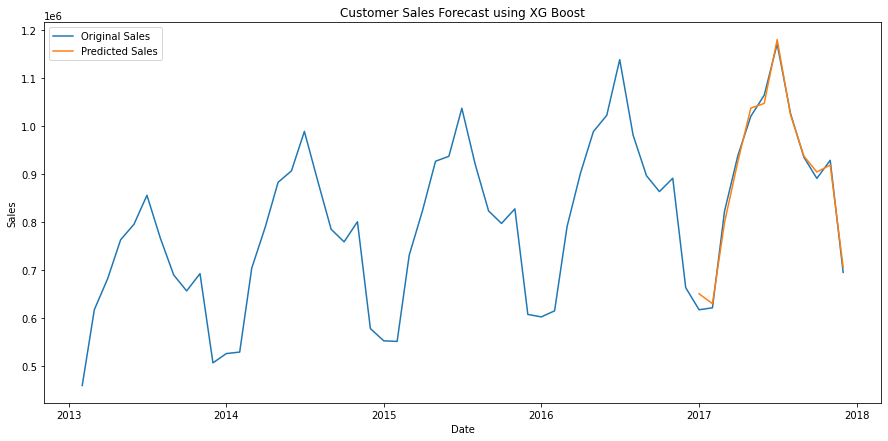

In [57]:
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['xgb_pred'])
plt.title("Customer Sales Forecast using XG Boost")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

#### LSTM

In [58]:
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [59]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train_lstm.shape[1], X_test_lstm.shape[2])))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [60]:
checkpoint_filepath = os.getcwd()
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
callbacks = [EarlyStopping(patience=5), model_checkpoint_callback]

In [61]:
history = model.fit(X_train_lstm, y_train, epochs=200, batch_size=1, validation_data=(X_test_lstm, y_test), callbacks=callbacks)

Epoch 1/200
25/35 [====================>.........] - ETA: 0s - loss: 0.2751  

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 8s 164ms/step - loss: 0.3061 - val_loss: 0.3414
Epoch 2/200
23/35 [==================>...........] - ETA: 0s - loss: 0.2943

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 153ms/step - loss: 0.2904 - val_loss: 0.3257
Epoch 3/200
21/35 [=================>............] - ETA: 0s - loss: 0.2567

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 149ms/step - loss: 0.2780 - val_loss: 0.3128
Epoch 4/200
21/35 [=================>............] - ETA: 0s - loss: 0.3132

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 143ms/step - loss: 0.2662 - val_loss: 0.2953
Epoch 5/200
23/35 [==================>...........] - ETA: 0s - loss: 0.2693

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 155ms/step - loss: 0.2547 - val_loss: 0.2778
Epoch 6/200
20/35 [================>.............] - ETA: 0s - loss: 0.2130

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 141ms/step - loss: 0.2374 - val_loss: 0.2580
Epoch 7/200
21/35 [=================>............] - ETA: 0s - loss: 0.1978    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 151ms/step - loss: 0.2206 - val_loss: 0.2406
Epoch 8/200
21/35 [=================>............] - ETA: 0s - loss: 0.2067

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 150ms/step - loss: 0.2059 - val_loss: 0.2244
Epoch 9/200
22/35 [=================>............] - ETA: 0s - loss: 0.1624

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 142ms/step - loss: 0.1913 - val_loss: 0.2101
Epoch 10/200
22/35 [=================>............] - ETA: 0s - loss: 0.1903

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 152ms/step - loss: 0.1787 - val_loss: 0.1971
Epoch 11/200
22/35 [=================>............] - ETA: 0s - loss: 0.1499

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 141ms/step - loss: 0.1659 - val_loss: 0.1862
Epoch 12/200
22/35 [=================>............] - ETA: 0s - loss: 0.0988

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 151ms/step - loss: 0.1559 - val_loss: 0.1784
Epoch 13/200
23/35 [==================>...........] - ETA: 0s - loss: 0.1243

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 150ms/step - loss: 0.1470 - val_loss: 0.1694
Epoch 14/200
22/35 [=================>............] - ETA: 0s - loss: 0.1285

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 142ms/step - loss: 0.1397 - val_loss: 0.1626
Epoch 15/200
22/35 [=================>............] - ETA: 0s - loss: 0.1448

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 150ms/step - loss: 0.1337 - val_loss: 0.1560
Epoch 16/200
21/35 [=================>............] - ETA: 0s - loss: 0.1742    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 139ms/step - loss: 0.1273 - val_loss: 0.1493
Epoch 17/200
21/35 [=================>............] - ETA: 0s - loss: 0.1618

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 153ms/step - loss: 0.1218 - val_loss: 0.1426
Epoch 18/200
22/35 [=================>............] - ETA: 0s - loss: 0.1126

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 149ms/step - loss: 0.1166 - val_loss: 0.1371
Epoch 19/200
21/35 [=================>............] - ETA: 0s - loss: 0.1616

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 140ms/step - loss: 0.1115 - val_loss: 0.1306
Epoch 20/200
22/35 [=================>............] - ETA: 0s - loss: 0.1231

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 152ms/step - loss: 0.1068 - val_loss: 0.1250
Epoch 21/200
21/35 [=================>............] - ETA: 0s - loss: 0.0655

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 151ms/step - loss: 0.1018 - val_loss: 0.1191
Epoch 22/200
22/35 [=================>............] - ETA: 0s - loss: 0.1040    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 157ms/step - loss: 0.0974 - val_loss: 0.1136
Epoch 23/200
21/35 [=================>............] - ETA: 0s - loss: 0.1107    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 141ms/step - loss: 0.0937 - val_loss: 0.1091
Epoch 24/200
22/35 [=================>............] - ETA: 0s - loss: 0.1335

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 153ms/step - loss: 0.0901 - val_loss: 0.1047
Epoch 25/200
21/35 [=================>............] - ETA: 0s - loss: 0.0657

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 152ms/step - loss: 0.0867 - val_loss: 0.1014
Epoch 26/200
20/35 [================>.............] - ETA: 0s - loss: 0.0885

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 144ms/step - loss: 0.0839 - val_loss: 0.0977
Epoch 27/200
20/35 [================>.............] - ETA: 0s - loss: 0.0596

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 152ms/step - loss: 0.0810 - val_loss: 0.0952
Epoch 28/200
21/35 [=================>............] - ETA: 0s - loss: 0.0518

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 141ms/step - loss: 0.0783 - val_loss: 0.0908
Epoch 29/200
20/35 [================>.............] - ETA: 0s - loss: 0.1240    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 154ms/step - loss: 0.0759 - val_loss: 0.0877
Epoch 30/200
33/35 [===========================>..] - ETA: 0s - loss: 0.0778   

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 157ms/step - loss: 0.0735 - val_loss: 0.0853
Epoch 31/200
20/35 [================>.............] - ETA: 0s - loss: 0.0699

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 153ms/step - loss: 0.0711 - val_loss: 0.0831
Epoch 32/200
22/35 [=================>............] - ETA: 0s - loss: 0.0731

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 151ms/step - loss: 0.0689 - val_loss: 0.0806
Epoch 33/200
21/35 [=================>............] - ETA: 0s - loss: 0.0352

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 141ms/step - loss: 0.0669 - val_loss: 0.0788
Epoch 34/200
21/35 [=================>............] - ETA: 0s - loss: 0.0462

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 162ms/step - loss: 0.0651 - val_loss: 0.0762
Epoch 35/200
18/35 [==============>...............] - ETA: 0s - loss: 0.1086

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 152ms/step - loss: 0.0631 - val_loss: 0.0741
Epoch 36/200
21/35 [=================>............] - ETA: 0s - loss: 0.0976

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 153ms/step - loss: 0.0611 - val_loss: 0.0721
Epoch 37/200
33/35 [===========================>..] - ETA: 0s - loss: 0.0627

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 139ms/step - loss: 0.0591 - val_loss: 0.0711
Epoch 38/200
22/35 [=================>............] - ETA: 0s - loss: 0.0900

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 153ms/step - loss: 0.0576 - val_loss: 0.0678
Epoch 39/200
30/35 [========================>.....] - ETA: 0s - loss: 0.0421

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 142ms/step - loss: 0.0558 - val_loss: 0.0664
Epoch 40/200
19/35 [===============>..............] - ETA: 0s - loss: 0.0121    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 157ms/step - loss: 0.0540 - val_loss: 0.0652
Epoch 41/200
33/35 [===========================>..] - ETA: 0s - loss: 0.0555

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 147ms/step - loss: 0.0525 - val_loss: 0.0629
Epoch 42/200
33/35 [===========================>..] - ETA: 0s - loss: 0.0537

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 138ms/step - loss: 0.0509 - val_loss: 0.0613
Epoch 43/200
21/35 [=================>............] - ETA: 0s - loss: 0.0260

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 175ms/step - loss: 0.0494 - val_loss: 0.0613
Epoch 44/200
21/35 [=================>............] - ETA: 0s - loss: 0.0548

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 139ms/step - loss: 0.0479 - val_loss: 0.0592
Epoch 45/200
22/35 [=================>............] - ETA: 0s - loss: 0.0317

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 165ms/step - loss: 0.0466 - val_loss: 0.0570
Epoch 46/200
19/35 [===============>..............] - ETA: 0s - loss: 0.0584    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 168ms/step - loss: 0.0453 - val_loss: 0.0553
Epoch 47/200
21/35 [=================>............] - ETA: 0s - loss: 0.0493    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 148ms/step - loss: 0.0438 - val_loss: 0.0546
Epoch 48/200
22/35 [=================>............] - ETA: 0s - loss: 0.0427    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 152ms/step - loss: 0.0426 - val_loss: 0.0530
Epoch 49/200
21/35 [=================>............] - ETA: 0s - loss: 0.0486

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 152ms/step - loss: 0.0415 - val_loss: 0.0519
Epoch 50/200
35/35 [==============================] - ETA: 0s - loss: 0.0404   

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 169ms/step - loss: 0.0404 - val_loss: 0.0510
Epoch 51/200
19/35 [===============>..............] - ETA: 0s - loss: 0.0505    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 157ms/step - loss: 0.0393 - val_loss: 0.0498
Epoch 52/200
20/35 [================>.............] - ETA: 0s - loss: 0.0615

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 149ms/step - loss: 0.0383 - val_loss: 0.0486
Epoch 53/200
22/35 [=================>............] - ETA: 0s - loss: 0.0352

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 177ms/step - loss: 0.0373 - val_loss: 0.0473
Epoch 54/200
35/35 [==============================] - ETA: 0s - loss: 0.0363   

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 179ms/step - loss: 0.0363 - val_loss: 0.0465
Epoch 55/200
20/35 [================>.............] - ETA: 0s - loss: 0.0200    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 7s 213ms/step - loss: 0.0354 - val_loss: 0.0461
Epoch 56/200
35/35 [==============================] - ETA: 0s - loss: 0.0345

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 188ms/step - loss: 0.0345 - val_loss: 0.0450
Epoch 57/200
35/35 [==============================] - ETA: 0s - loss: 0.0338   

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 174ms/step - loss: 0.0338 - val_loss: 0.0443
Epoch 58/200
34/35 [============================>.] - ETA: 0s - loss: 0.0245   

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 172ms/step - loss: 0.0329 - val_loss: 0.0431
Epoch 59/200
22/35 [=================>............] - ETA: 0s - loss: 0.0331    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 140ms/step - loss: 0.0322 - val_loss: 0.0425
Epoch 60/200
22/35 [=================>............] - ETA: 0s - loss: 0.0179

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 153ms/step - loss: 0.0314 - val_loss: 0.0414
Epoch 61/200
21/35 [=================>............] - ETA: 0s - loss: 0.0334    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 151ms/step - loss: 0.0305 - val_loss: 0.0405
Epoch 62/200
23/35 [==================>...........] - ETA: 0s - loss: 0.0297    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 144ms/step - loss: 0.0297 - val_loss: 0.0405
Epoch 63/200
22/35 [=================>............] - ETA: 0s - loss: 0.0169

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 157ms/step - loss: 0.0290 - val_loss: 0.0398
Epoch 64/200
24/35 [===================>..........] - ETA: 0s - loss: 0.0155

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 143ms/step - loss: 0.0286 - val_loss: 0.0385
Epoch 65/200
20/35 [================>.............] - ETA: 0s - loss: 0.0331    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 7s 207ms/step - loss: 0.0279 - val_loss: 0.0365
Epoch 66/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0269 - val_loss: 0.0365
Epoch 67/200
23/35 [==================>...........] - ETA: 0s - loss: 0.0393

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 140ms/step - loss: 0.0266 - val_loss: 0.0351
Epoch 68/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0255 - val_loss: 0.0353
Epoch 69/200
22/35 [=================>............] - ETA: 0s - loss: 0.0257    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 152ms/step - loss: 0.0250 - val_loss: 0.0343
Epoch 70/200
21/35 [=================>............] - ETA: 0s - loss: 0.0163

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 140ms/step - loss: 0.0245 - val_loss: 0.0333
Epoch 71/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0238 - val_loss: 0.0333
Epoch 72/200
20/35 [================>.............] - ETA: 0s - loss: 0.0148

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 153ms/step - loss: 0.0234 - val_loss: 0.0325
Epoch 73/200
20/35 [================>.............] - ETA: 0s - loss: 0.0135

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 148ms/step - loss: 0.0227 - val_loss: 0.0314
Epoch 74/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0221 - val_loss: 0.0316
Epoch 75/200
22/35 [=================>............] - ETA: 0s - loss: 0.0124

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 150ms/step - loss: 0.0216 - val_loss: 0.0302
Epoch 76/200
21/35 [=================>............] - ETA: 0s - loss: 0.0222

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 153ms/step - loss: 0.0211 - val_loss: 0.0292
Epoch 77/200
20/35 [================>.............] - ETA: 0s - loss: 0.0140    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 186ms/step - loss: 0.0205 - val_loss: 0.0287
Epoch 78/200
30/35 [========================>.....] - ETA: 0s - loss: 0.0230   

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 7s 206ms/step - loss: 0.0201 - val_loss: 0.0287
Epoch 79/200
35/35 [==============================] - ETA: 0s - loss: 0.0194   

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 10s 293ms/step - loss: 0.0194 - val_loss: 0.0279
Epoch 80/200
18/35 [==============>...............] - ETA: 0s - loss: 0.0131    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 160ms/step - loss: 0.0190 - val_loss: 0.0276
Epoch 81/200
22/35 [=================>............] - ETA: 0s - loss: 0.0178

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 151ms/step - loss: 0.0184 - val_loss: 0.0275
Epoch 82/200
21/35 [=================>............] - ETA: 0s - loss: 0.0183    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 140ms/step - loss: 0.0181 - val_loss: 0.0264
Epoch 83/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0176 - val_loss: 0.0266
Epoch 84/200
23/35 [==================>...........] - ETA: 0s - loss: 0.0171

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 160ms/step - loss: 0.0172 - val_loss: 0.0257
Epoch 85/200
21/35 [=================>............] - ETA: 0s - loss: 0.0190

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 150ms/step - loss: 0.0169 - val_loss: 0.0255
Epoch 86/200
22/35 [=================>............] - ETA: 0s - loss: 0.0093

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 142ms/step - loss: 0.0163 - val_loss: 0.0246
Epoch 87/200
21/35 [=================>............] - ETA: 0s - loss: 0.0170    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 169ms/step - loss: 0.0161 - val_loss: 0.0246
Epoch 88/200
21/35 [=================>............] - ETA: 0s - loss: 0.0169

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 176ms/step - loss: 0.0155 - val_loss: 0.0244
Epoch 89/200
21/35 [=================>............] - ETA: 0s - loss: 0.0173

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 8s 244ms/step - loss: 0.0153 - val_loss: 0.0242
Epoch 90/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0149 - val_loss: 0.0245
Epoch 91/200
20/35 [================>.............] - ETA: 0s - loss: 0.0152    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 187ms/step - loss: 0.0145 - val_loss: 0.0223
Epoch 92/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0139 - val_loss: 0.0235
Epoch 93/200
35/35 [==============================] - 0s 6ms/step - loss: 0.0135 - val_loss: 0.0231
Epoch 94/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0132 - val_loss: 0.0225
Epoch 95/200
17/35 [=============>................] - ETA: 0s - loss: 0.0175    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 169ms/step - loss: 0.0129 - val_loss: 0.0218
Epoch 96/200
20/35 [================>.............] - ETA: 0s - loss: 0.0138    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 177ms/step - loss: 0.0124 - val_loss: 0.0211
Epoch 97/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0120 - val_loss: 0.0216
Epoch 98/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0118 - val_loss: 0.0213
Epoch 99/200
19/35 [===============>..............] - ETA: 0s - loss: 0.0086    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 159ms/step - loss: 0.0114 - val_loss: 0.0201
Epoch 100/200
19/35 [===============>..............] - ETA: 0s - loss: 0.0188

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 153ms/step - loss: 0.0110 - val_loss: 0.0201
Epoch 101/200
20/35 [================>.............] - ETA: 0s - loss: 0.0071    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 151ms/step - loss: 0.0109 - val_loss: 0.0200
Epoch 102/200
20/35 [================>.............] - ETA: 0s - loss: 0.0023    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 174ms/step - loss: 0.0104 - val_loss: 0.0196
Epoch 103/200
32/35 [==========================>...] - ETA: 0s - loss: 0.0110   

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 169ms/step - loss: 0.0104 - val_loss: 0.0191
Epoch 104/200
19/35 [===============>..............] - ETA: 0s - loss: 0.0112

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 5s 149ms/step - loss: 0.0099 - val_loss: 0.0181
Epoch 105/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0098 - val_loss: 0.0184
Epoch 106/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0093 - val_loss: 0.0193
Epoch 107/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0089 - val_loss: 0.0182
Epoch 108/200
22/35 [=================>............] - ETA: 0s - loss: 0.0048    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 7s 194ms/step - loss: 0.0088 - val_loss: 0.0175
Epoch 109/200
22/35 [=================>............] - ETA: 0s - loss: 0.0125

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 8s 233ms/step - loss: 0.0086 - val_loss: 0.0173
Epoch 110/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0083 - val_loss: 0.0177
Epoch 111/200
31/35 [=========================>....] - ETA: 0s - loss: 0.0089

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 178ms/step - loss: 0.0080 - val_loss: 0.0171
Epoch 112/200
19/35 [===============>..............] - ETA: 0s - loss: 0.0125    

INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


INFO:tensorflow:Assets written to: e:\Embedded Robotics\Blog Articles\Data Science\datascience\customer_sales_prediction\assets


35/35 [==============================] - 6s 185ms/step - loss: 0.0078 - val_loss: 0.0161
Epoch 113/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0077 - val_loss: 0.0161
Epoch 114/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0174
Epoch 115/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 0.0171
Epoch 116/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0069 - val_loss: 0.0162
Epoch 117/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.0167


In [62]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

         loss  val_loss
0    0.306095  0.341392
1    0.290393  0.325653
2    0.277971  0.312775
3    0.266157  0.295267
4    0.254720  0.277838
..        ...       ...
112  0.007694  0.016077
113  0.007322  0.017401
114  0.007381  0.017109
115  0.006858  0.016170
116  0.006809  0.016729

[117 rows x 2 columns]


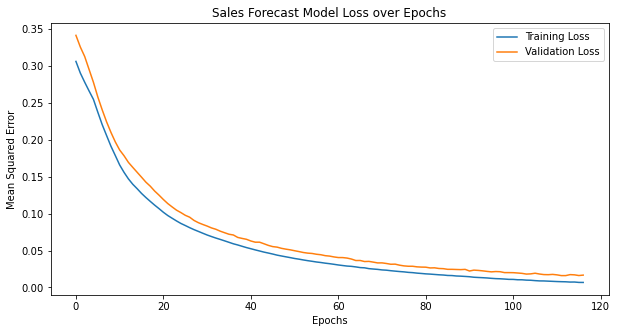

In [63]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('Sales Forecast Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [64]:
lstm_pred = model.predict(X_test_lstm, batch_size=1)

In [65]:
lstm_pred = lstm_pred.reshape(-1,1)
lstm_pred_test_set = np.concatenate([lstm_pred,X_test], axis=1)
lstm_pred_test_set = scaler.inverse_transform(lstm_pred_test_set)

In [66]:
result_list = []
for index in range(0, len(lstm_pred_test_set)):
    result_list.append(lstm_pred_test_set[index][0] + act_sales[index])
lstm_pred_series = pd.Series(result_list, name='lstm_pred')
predict_df = predict_df.merge(lstm_pred_series, left_index=True, right_index=True)

In [67]:
lstm_rmse = np.sqrt(mean_squared_error(predict_df['lstm_pred'], monthly_sales['sales'][-12:]))
lstm_mae = mean_absolute_error(predict_df['lstm_pred'], monthly_sales['sales'][-12:])
lstm_r2 = r2_score(predict_df['lstm_pred'], monthly_sales['sales'][-12:])
print('LSTM RMSE: ', lstm_rmse)
print('LSTM MAE: ', lstm_mae)
print('LSTM R2 Score: ', lstm_r2)

LSTM RMSE:  26363.93061819898
LSTM MAE:  18458.584227992844
LSTM R2 Score:  0.9718042329950558


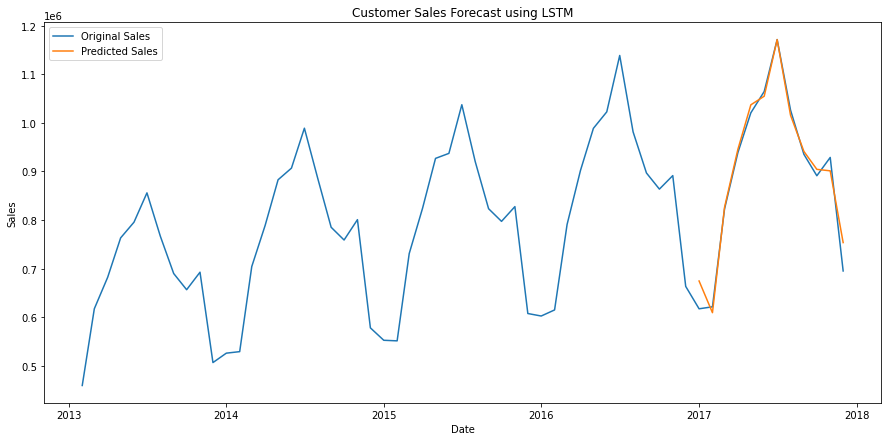

In [68]:
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['lstm_pred'])
plt.title("Customer Sales Forecast using LSTM")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

#### Comparing Linear Regression, Random Forest, XG Boost, LSTM

In [77]:
linreg_stats = [linreg_rmse, linreg_mae, linreg_r2]
rf_stats = [rf_rmse, rf_mae, rf_r2]
xgb_stats = [xgb_rmse, xgb_mae, xgb_r2]
lstm_stats = [lstm_rmse, lstm_mae, lstm_r2]

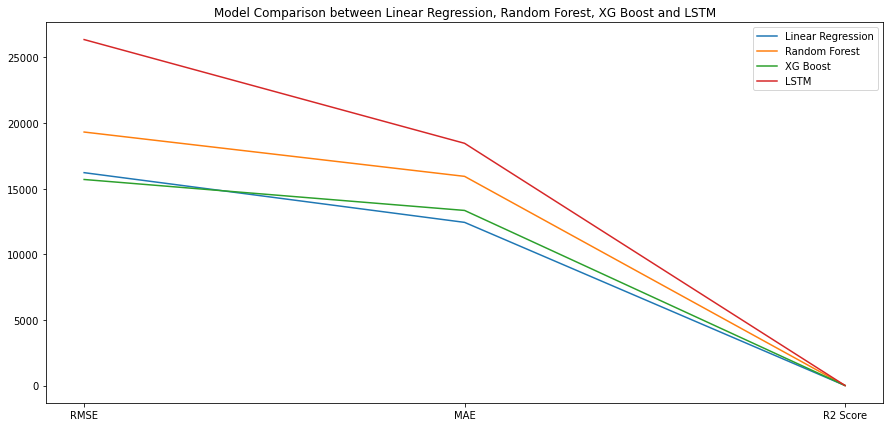

In [84]:
plt.figure(figsize=(15,7))
plt.plot(linreg_stats)
plt.plot(rf_stats)
plt.plot(xgb_stats)
plt.plot(lstm_stats)
plt.title("Model Comparison between Linear Regression, Random Forest, XG Boost and LSTM")
plt.xticks([0,1,2], labels=['RMSE','MAE','R2 Score'])
plt.legend(["Linear Regression", "Random Forest", "XG Boost", "LSTM"])
plt.show()